In [1]:
from utils import *
import numpy as np
from numpy.random import seed
import tensorflow as tf
import datetime
import pandas as pd 
import matplotlib.pyplot as plt

# Custom imports
from nets import unet, unet_2d, unet_bi, unetpp, unetpp_2d, scSEunet, scSEunetpp
from config import get_config

cfg = get_config()

X,  Y, paths  = load_dataset('data_256_200_64/test/', return_paths=True, pad=28)
Xx, Y, paths  = load_dataset('data_256_200_64/test/', return_paths=True, addcoords=True, pad=28)

Using TensorFlow backend.
100%|██████████| 10/10 [00:01<00:00,  9.14it/s]


In [2]:
model = scSEunet(256, 256, 64, 1)
model.load_weights('ckpt/256_model_scseunet2_fl.p5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [3]:
outs = model.predict(X, batch_size=1)

In [4]:
if type(outs) == type([]):
    outs = outs[-1]

export_outs(X, Y, outs, 'outs/global/', paths=paths)

def summary(outs, Y):
    tabledata = []
    means = [0] * 5
    for i in range(outs.shape[0]):
        row = [paths[i]]
        mean = 0
        for j in range(1, 6):
            yt = Y[i,:,:,:,j]
            yp = outs[i,:,:,:,j]

            dice = dice_coef(yt, yp, numpy=True) * 100
            row.append('%.2f' % dice)
            
            mean += (dice / 5)
            means[j-1] += (dice / outs.shape[0])

        row.append('%.2f' % mean)
        tabledata.append(row)
    tabledata.append(['Mean'] + ['%.2f' % m for m in means] + ['%.2f' % np.mean(means)])
    df = pd.DataFrame(tabledata, columns=['Name', 'Liver', 'Kidney', 'Stomach', 'Duodenum', 'Largebowel', 'Mean'])
    df = df.set_index('Name')
    return df

Exporting...


In [5]:
seg = ind2onehot(outs.argmax(axis=-1))

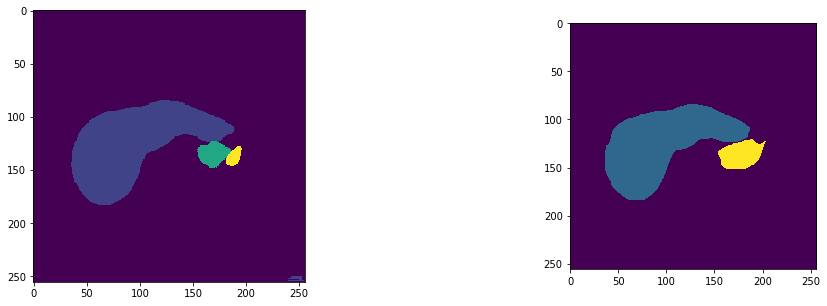

In [6]:
seg_global = outs.argmax(axis=-1)
seg_actual = Y.argmax(axis=-1)
slc = 20
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(seg_global[9,:,:,slc])
plt.subplot(133)
plt.imshow(seg_actual[9,:,:,slc])

In [7]:
summary(ind2onehot(seg_global), Y)

,Liver,Kidney,Stomach,Duodenum,Largebowel,Mean
Name,,,,,,
orig_data_111.mat,91.38,88.10,84.23,2.41,59.13,65.05
orig_data_112.mat,91.98,80.06,87.09,3.29,63.20,65.13
orig_data_113.mat,90.47,3.01,73.05,4.64,42.92,42.82
orig_data_114.mat,90.32,87.42,78.70,9.75,85.19,70.28
orig_data_115.mat,94.17,88.40,81.30,32.66,75.99,74.50
orig_data_116.mat,93.27,68.53,87.07,6.21,82.21,67.46
orig_data_117.mat,94.63,92.90,62.27,12.69,82.72,69.04
orig_data_118.mat,93.28,93.05,78.74,36.21,77.02,75.66
orig_data_119.mat,93.17,91.56,83.86,67.68,78.89,83.03


# Local refinement

In [8]:
X = np.concatenate((Xx, outs), axis=4)
X.shape

(10, 256, 256, 64, 10)

In [9]:
output = np.zeros_like(outs)
output.shape

(10, 256, 256, 64, 6)

In [10]:
patch_model = unet(64, 64, 16, 10, bn=True)
patch_model.load_weights('ckpt_patches/model_1.unet_patches.p5')

In [11]:
steps = (32,32,8)

In [21]:
for i in range(0,256-64+1,steps[1]):
    for j in range(0,256-64+1,steps[0]):
        for k in range(0,64-16+1,steps[2]):
            iend = i+64
            jend = j+64
            kend = k+16
            patch = X[:,j:jend,i:iend,k:kend].astype('float32')
            out = patch_model.predict(patch, batch_size=1)
            output[:,j:jend,i:iend,k:kend] = output[:,j:jend,i:iend,k:kend] + out

In [22]:
out.shape

(10, 64, 64, 16, 6)

In [24]:
seg_local = output.argmax(axis=-1)
slc = 40

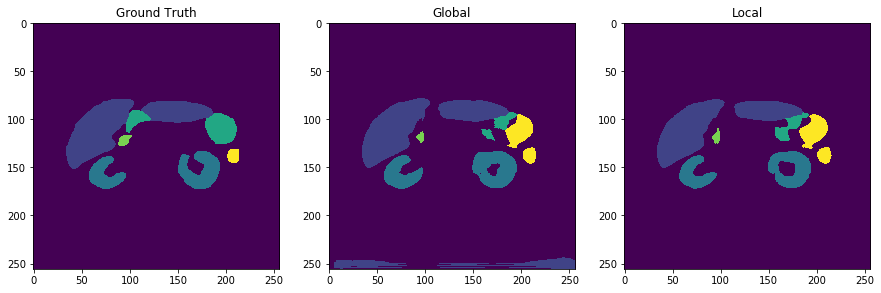

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(seg_actual[9,:,:,slc])
plt.title('Ground Truth')
plt.subplot(132)
plt.imshow(seg_global[9,:,:,slc])
plt.title('Global')
plt.subplot(133)
plt.imshow(seg_local[9,:,:,slc])
plt.title('Local')
plt.show()

In [26]:
if type(output) == type([]):
    output = output[-1]

# export_outs(X, Y, output, 'outs/local/', paths=paths)

249434780

In [32]:
#seg = ind2onehot(output.argmax(axis=-1))
summary(ind2onehot(seg_local), Y)


,Liver,Kidney,Stomach,Duodenum,Largebowel,Mean
Name,,,,,,
orig_data_111.mat,89.90,88.02,86.34,25.38,60.70,70.07
orig_data_112.mat,92.76,83.72,87.09,9.73,59.24,66.51
orig_data_113.mat,93.19,0.01,74.36,2.77,44.24,42.91
orig_data_114.mat,94.87,90.32,78.64,28.11,84.17,75.22
orig_data_115.mat,94.66,90.22,81.04,62.66,73.45,80.41
orig_data_116.mat,92.92,66.01,85.64,66.35,82.93,78.77
orig_data_117.mat,94.60,93.47,61.41,36.95,84.01,74.09
orig_data_118.mat,94.15,93.83,79.13,41.99,77.00,77.22
orig_data_119.mat,93.77,93.12,85.44,60.52,79.73,82.52
